In [1]:
import numpy as np
import pandas as pd
import torch
import copy
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import spconv.pytorch as spconv
import matplotlib.pyplot as plt
import mytools
import mymodels

# Prepare Data

In [2]:
# Read pandas dataframe with all information about sparse training tensors
file_loc = '/mnt/scratch/lustre_01/scratch/majd/sparse_training_tensors2/'
st_info = pd.read_pickle(file_loc+'sparse_tensor_info.pk')
st_info

,dir,offset,diff,energy,true_index
0,"[0.5923457337920527, -0.5369941830475861, -0.6...","[-0.851898273495669, 2.1253245532459824, 0.445...",0.046168,40,0
1,"[-0.6164927192719855, 0.5695943083433039, -0.5...","[-1.017085182270888, -1.6805460012244295, 1.10...",0.028843,40,1
2,"[0.6322337566233259, -0.16773581669128113, -0....","[-0.10613203070195368, 0.22289410895907838, 1....",0.025293,40,2
3,"[0.2908139608694231, -0.8484810341097399, -0.4...","[-1.0096727220437194, 1.2613684348817842, 1.42...",0.034410,40,3
4,"[0.7738521869833273, -0.07925597736546798, -0....","[0.7752193984015442, 0.8404383794565299, 0.902...",0.033654,40,4
...,...,...,...,...,...
553707,"[0.11036389010940843, 0.46281844086272667, 0.8...","[0.6593805240528293, 2.348973170119055, -0.075...",0.033278,50,553707
553708,"[0.4836130500718614, -0.1550806338384979, 0.86...","[-0.31985612955816756, 0.7787766345838262, 1.1...",0.045868,50,553708
553709,"[0.2802832084314196, 0.7103957250052321, -0.64...","[-0.3702837943470353, -1.5113524440094708, 2.8...",0.035873,50,553709
553710,"[0.529279350828489, -0.20877957756567822, -0.8...","[-1.697581969982567, -1.1125666386100619, 1.96...",0.039379,50,553710


In [3]:
# Make custom dataset
MyDataset = mytools.CustomDataset(dir_loc = file_loc, st_info = st_info)

# Split datat into training, validation, and testing sets
train_dataset, val_dataset = torch.utils.data.random_split(MyDataset,[0.8, 0.2], generator=torch.Generator().manual_seed(42))

print("Training samples: ", len(train_dataset))
print("Validation samples: ", len(val_dataset))

# Create training and validation DataLoaders
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Training samples:  442970
Validation samples:  110742


In [4]:
# Print tensor shapes
for X_plot, y_plot, offset_plot in train_dataloader:
    print(f"Shape of X [N, C, H, W, D]: {X_plot.shape}")
    print(f"Shape of y: {y_plot.shape} {y_plot.dtype}")
    print("Offsets: ", offset_plot.shape)
    break


Shape of X [N, C, H, W, D]: torch.Size([64, 120, 120, 120, 1])
Shape of y: torch.Size([64, 3]) torch.float32
Offsets:  torch.Size([64, 3])


In [5]:
#Record shape of voxel grid
grid_shape = X_plot.shape[1:4]
print("Voxel grid shape: " , grid_shape)

Voxel grid shape:  torch.Size([120, 120, 120])


# Visualize a sample

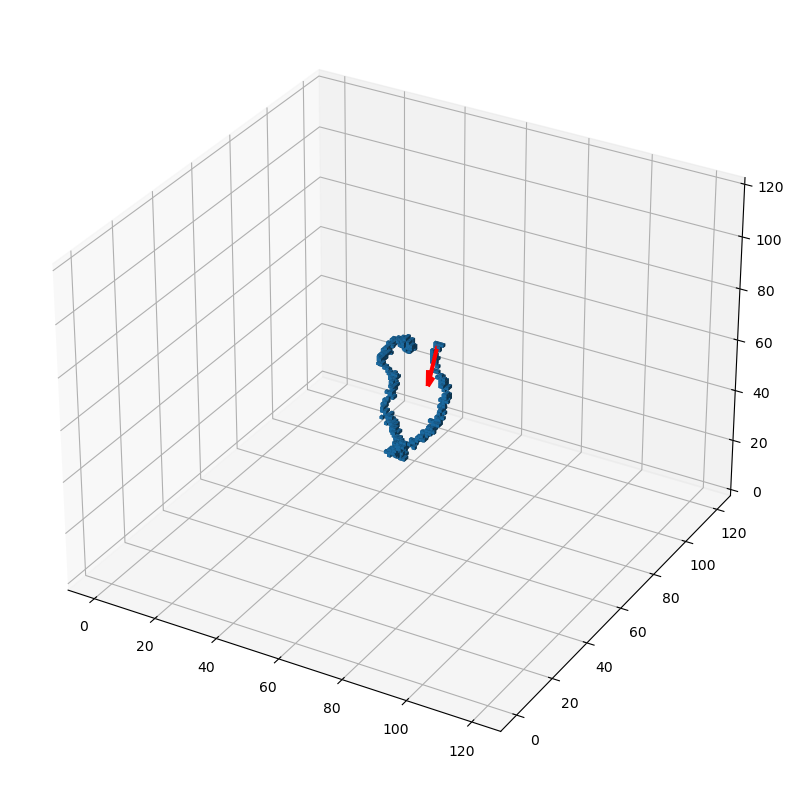

In [6]:
# Plot an example as a sanity check

# x/y/z length being kept in cm
eff_l = mytools.voxel_grid['eff_l']
# Voxel size in cm
vox_l = mytools.voxel_grid['vox_l']

#Convert to dense, reshape and convert to numpy
X_plot = X_plot.to_dense().reshape(-1, 1, 120, 120, 120).numpy()

index = 2
mytools.plot_tensor_dir(tensor = X_plot[index], start = offset_plot[index].numpy(), direction = y_plot[index].numpy(), eff_l=eff_l, vox_l=vox_l)



# Initialize Convnet

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

model = mymodels.spConvnet(shape = grid_shape ).to(device)
print(model)

Using cuda device
spConvnet(
  (net): SparseSequential(
    (0): SparseConv3d(1, 50, kernel_size=[6, 6, 6], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (1): ReLU()
    (2): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (3): SparseConv3d(50, 30, kernel_size=[4, 4, 4], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.Native)
    (4): ReLU()
    (5): SparseConv3d(30, 20, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (6): ReLU()
    (7): SparseMaxPool3d(kernel_size=[2, 2, 2], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], algo=ConvAlgo.MaskImplicitGemm)
    (8): ToDense()
  )
  (fc1): Linear(in_features=34560, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=30, bi

# Train the model

In [8]:
# Specify optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.0001, betas=(0.94, 0.999), eps=1e-07)


In [9]:
# Implement early stopping in training loop
# Stop if validation loss has not decreased for the last [patience] epochs
# The model with the lowest loss is stored
patience = 2

Training_losses = np.array([])
Validation_losses = np.array([])

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    Training_losses = np.append(Training_losses, mytools.train(train_dataloader, model, mytools.CSloss, optimizer, device))
    Validation_losses = np.append(Validation_losses, mytools.validate(val_dataloader, model, mytools.CSloss, device))
    
    # Keep a running copy of the model with the lowest loss
    if Validation_losses[-1] == np.min(Validation_losses):
        final_model = copy.deepcopy(model)
    
    if len(Validation_losses) > patience:
        if np.sum((Validation_losses[-1*np.arange(patience)-1] - Validation_losses[-1*np.arange(patience)-2]) < 0) == 0:
            print("Stopping early!")
            break
            
print("Done!")

Epoch 1
-------------------------------
Current batch training loss: -0.058706  [    0/442970]
Current batch training loss: -0.258456  [ 6400/442970]
Current batch training loss: -0.345270  [12800/442970]
Current batch training loss: -0.425889  [19200/442970]
Current batch training loss: -0.480507  [25600/442970]
Current batch training loss: -0.536121  [32000/442970]
Current batch training loss: -0.505762  [38400/442970]
Current batch training loss: -0.363273  [44800/442970]
Current batch training loss: -0.444813  [51200/442970]
Current batch training loss: -0.523795  [57600/442970]
Current batch training loss: -0.594737  [64000/442970]
Current batch training loss: -0.583356  [70400/442970]
Current batch training loss: -0.699692  [76800/442970]
Current batch training loss: -0.628760  [83200/442970]
Current batch training loss: -0.636927  [89600/442970]
Current batch training loss: -0.685288  [96000/442970]
Current batch training loss: -0.610723  [102400/442970]
Current batch training l

# Visualize Training

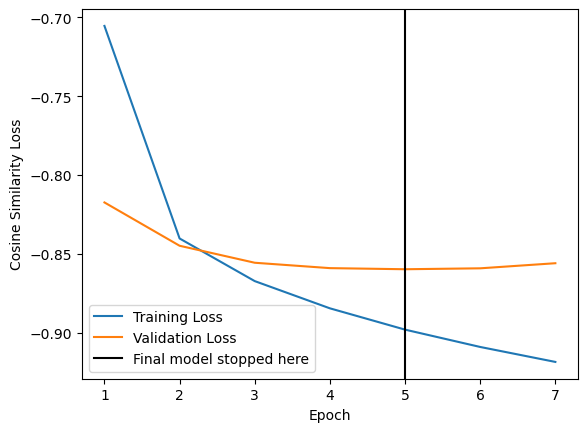

In [10]:
# Plot Training and Validation Loss
# Indicate where the final model stopped training

best_epoch = np.argmin(Validation_losses)+1

plt.plot(np.arange(len(Training_losses))+1,Training_losses,label="Training Loss")
plt.plot(np.arange(len(Validation_losses))+1,Validation_losses,label="Validation Loss")
plt.axvline(best_epoch,label="Final model stopped here",color='k')
plt.xlabel('Epoch')
plt.ylabel('Cosine Similarity Loss')
plt.legend()


# Save the Model

In [11]:
torch.save(final_model, "../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt")
print("Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt")

Saved PyTorch Model State to ../3D_Heteroscedastic_Convnet_models/3D_CNN_spconv.pt
